## Preliminares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I, StateFn, Gradient, PauliExpectation
from qiskit.utils import  algorithm_globals, QuantumInstance
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import SamplerQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA



algorithm_globals.random_seed = 42



from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere, plot_sampled_features, get_binary_dataset
from QWNN import  quantum_weightless_neuron_ry, quantum_weightless_nn
from quantum_encoding import angle_encoding
from Aux_QuantumML import ttn, get_opflow_qnn



Experimentos com uma Rede no dataset Heart

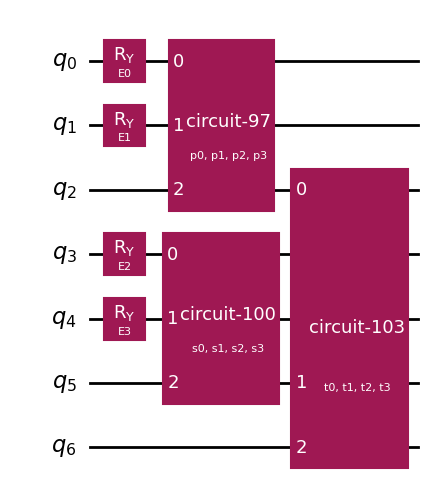

In [2]:
hamiltonian_qwnn = Z ^ I ^ I ^ I ^ I ^ I ^ I
qwnn_qc = QuantumCircuit(7)
feature_map = angle_encoding(4)
qwnn_qc.append(feature_map, [0,1,3,4])
ansatz_qwnn= quantum_weightless_nn()
qwnn_qc.append(ansatz_qwnn, [0,1,2,3,4,5,6])
qwnn_qc.decompose().draw('mpl', style='iqx')

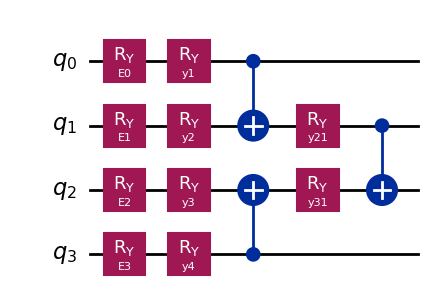

In [3]:
hamiltonian_ttn = I ^ Z ^ I ^ I 
ttn_qc = QuantumCircuit(4)
ttn_qc.append(feature_map, [0,1,2,3])
ansatz_ttn= ttn()
ttn_qc.append(ansatz_ttn, [0,1,2,3])
ttn_qc.decompose().draw('mpl', style='iqx')

In [4]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()



def run_experiments(X, y, n_times, ansatz_chosen= "QWNN", apply_pca = False, pca_components = 4, normalization=np.pi):
    if(ansatz_chosen=="QWNN"):
        quantum_circuit = qwnn_qc
        ansatz = ansatz_qwnn
        hamiltonian = hamiltonian_qwnn
    if(ansatz_chosen=="TTN"):
        quantum_circuit = ttn_qc
        ansatz = ansatz_ttn
        hamiltonian = hamiltonian_ttn
    #normalization = np.pi
    score_list = []
    if(apply_pca): pca = PCA(pca_components)
    for i in range(n_times):
        print("iteracao :", i)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
        if(apply_pca):
            X_train_new = pca.fit_transform(X_train)
            X_test_new = pca.transform(X_test)
        else:
            X_train_new, X_test_new = X_train, X_test
        minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_new)
        X_train_new = minmax_scale.transform(X_train_new)
        X_test_new = minmax_scale.transform(X_test_new)
        qnn = get_opflow_qnn(quantum_circuit, feature_map, ansatz, hamiltonian)
        clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
        clf.fit(X_train_new, y_train)
        score = clf.score(X_test_new, y_test)
        score_list.append(score)
        print("score: ", score)
    print("Mean: ", np.mean(score_list))
    print("Std: ", np.std(score_list))
    print(score_list)
    return score_list

In [3]:
'''
def get_opflow_qnn(quantum_circuit, feature_map, ansatz, hamiltonian, seed=42):
    hamiltonian = Z ^ I ^ I ^ I ^ I ^ I ^ I
    algorithm_globals.random_seed = 42
    simulator = Aer.get_backend("aer_simulator", device="GPU", max_parallel_threads =0, max_parallel_experiments =0)
    #simulator.set_options(device='GPU')
    quantum_instance = QuantumInstance(simulator, shots=1024, seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed)
    qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(quantum_circuit)
    qnn = OpflowQNN(qnn_expectation, 
                    input_params=list(feature_map.parameters), 
                    weight_params=list(ansatz.parameters),
                    exp_val=PauliExpectation(),
                    gradient=Gradient(),  
                    quantum_instance=quantum_instance)
    return qnn

'''

## Base de dados selecionada:

In [15]:
heart = pd.read_csv("data/heart.csv")
heart.head(5)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [10]:
heart_np = heart.to_numpy()
data = heart_np[:, 0:-1]
target = heart_np[:, -1]

In [14]:
data[0]

array([ 52.,   1.,   0., 125., 212.,   0.,   1., 168.,   0.,   1.,   2.,
         2.,   3.])

In [17]:
target[1]

0.0

In [21]:
data.shape

(768, 8)

In [29]:
class_a = 0
class_b = 1
X_all = data
Y_all = target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)


In [30]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

In [31]:
X_pca.shape

(768, 4)

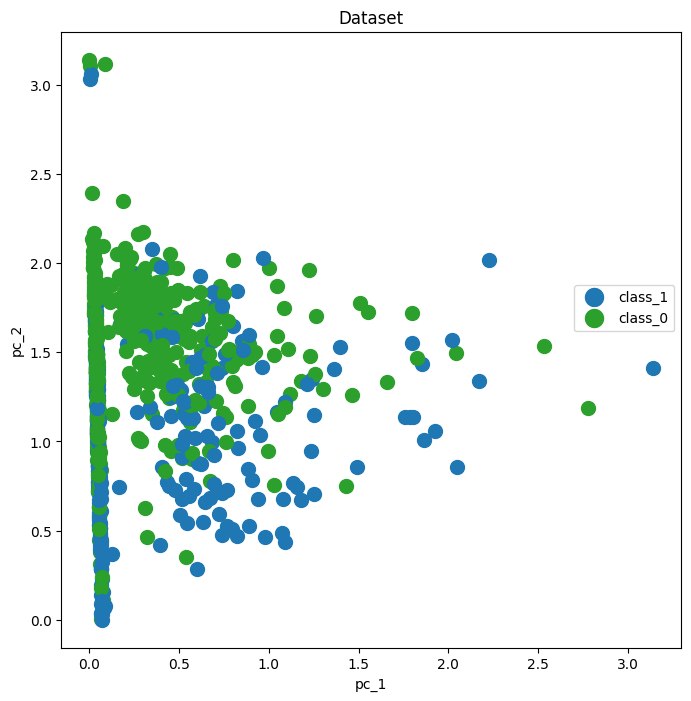

In [12]:
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_pca)
X_pca = minmax_scale.transform(X_pca)
plot_sampled_features(X_pca[:, [0,1]], y, axis_x_name='pc_1', axis_y_name='pc_2', class_name_minus="class_0", class_name_plus="class_1")

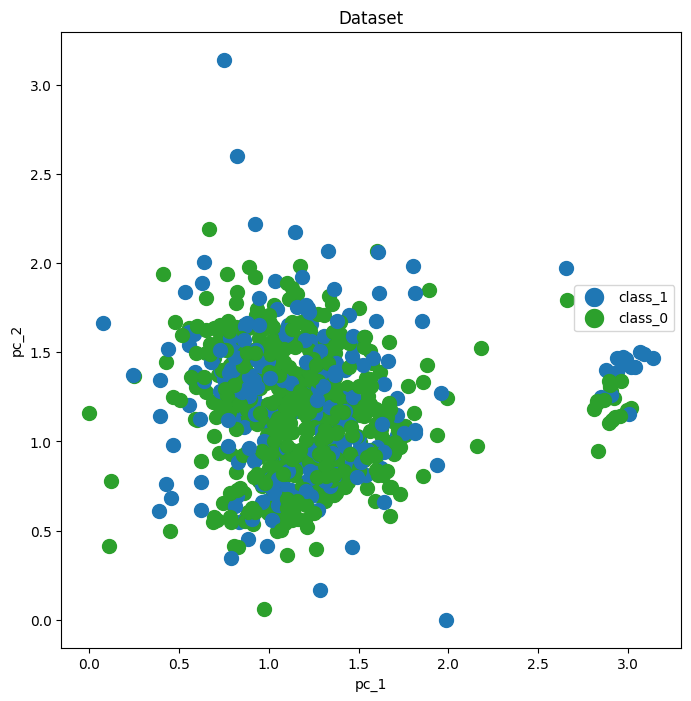

In [34]:
plot_sampled_features(X_pca[:, [2,3]], y, axis_x_name='pc_1', axis_y_name='pc_2', class_name_minus="class_0", class_name_plus="class_1")

# QWNN

## 1 vez + Grafico

In [19]:
heart = pd.read_csv("data/heart.csv")
heart_np = heart.to_numpy()
X_all = heart_np[:, 0:-1]
Y_all = heart_np[:, -1]
class_a = 0
class_b=1
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

In [21]:
qnn = get_opflow_qnn(qwnn_qc, feature_map, ansatz_qwnn, hamiltonian_qwnn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
X_train_pca = minmax_scale.transform(X_train_pca)
X_test_pca = minmax_scale.transform(X_test_pca)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_pca, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_pca, y_test)

KeyboardInterrupt: 

# Rodando várias vezes

In [9]:
pima = pd.read_csv("data/diabetes.csv")
pima_np = pima.to_numpy()
X_all = pima_np[:, 0:8]
Y_all = pima_np[:, 8]
class_a = 0
class_b=1
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=2, ansatz_chosen="QWNN", apply_pca=True, pca_components=4)

iteracao : 0
score:  0.6493506493506493
iteracao : 1
score:  0.6493506493506493
Mean:  0.6493506493506493
Std:  0.0
[0.6493506493506493, 0.6493506493506493]


# TTN

In [ ]:
qnn = get_opflow_qnn(ttn_qc, feature_map, ansatz_ttn, hamiltonian_ttn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
X_train_pca = minmax_scale.transform(X_train_pca)
X_test_pca = minmax_scale.transform(X_test_pca)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_pca, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_pca, y_test)

Rodando Várias Vezes

In [11]:
heart = pd.read_csv("data/heart.csv")
heart_np = heart.to_numpy()
X_all = heart_np[:, 0:-1]
Y_all = heart_np[:, -1]
class_a = 0
class_b=1
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=3, ansatz_chosen="TTN", apply_pca=True, pca_components=4)

iteracao : 0
score:  0.7024390243902439
iteracao : 1
score:  0.6731707317073171
iteracao : 2
score:  0.7121951219512195
Mean:  0.6959349593495935
Std:  0.0165821772799765
[0.7024390243902439, 0.6731707317073171, 0.7121951219512195]


In [12]:
print(score_list)

[0.7024390243902439, 0.6731707317073171, 0.7121951219512195]
